#**Visualization of P300 and no-P300 epochs - BCI Competition III**

#Access GoogleDrive

In [ ]:
from google.colab import drive

In [ ]:
import matplotlib.pyplot as plt   
import numpy as np                
import os                         
import pandas as pd
from pathlib import Path          
from scipy.io import loadmat      
from scipy import signal          
from tqdm.auto import tqdm        
from google.colab import drive
import h5py

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CHANNEL_LOCATIONS_FILE_PATH = Path('drive') / 'MyDrive' / 'workshop_neuro'  / 'material'/ 'channels.csv'
SUBJECT_B_TRAIN_FILE_PATH = Path('drive') / 'MyDrive' / 'workshop_neuro'  / 'material'/ 'Subject_B_Train.mat'
SUBJECT_B_TEST_FILE_PATH = Path('drive') / 'MyDrive' / 'workshop_neuro'  / 'material'/ 'Subject_B_Test.mat'
SUBJECT_B_TEST_CHARS_FILE_PATH = Path('drive') / 'MyDrive' / 'workshop_neuro' / 'material' / 'TestTargetChars.mat'
CHANNEL_LOCATIONS_FILE_PATH.exists()

True

# Channels extraction

In [ ]:
if not CHANNEL_LOCATIONS_FILE_PATH.exists():
    print(f"Missing file: {CHANNEL_LOCATIONS_FILE_PATH}")
else:
  CHANNELS = []
  # Read file content
  with open(CHANNEL_LOCATIONS_FILE_PATH, "r") as f:
    file_content = f.read()
    # Loop over all rows (except first one)
    for row in file_content.split("\n")[1:]: 
      # Skip missing rows
      if row == '':
        continue
      CHANNELS.append(row)

#Subject B extraction

## Subject B train 

In [ ]:
if not SUBJECT_B_TRAIN_FILE_PATH.exists():
    print(f"Missing file: {SUBJECT_B_TRAIN_FILE_PATH}")
else:
  
  # Load the required data
  data_train = loadmat(SUBJECT_B_TRAIN_FILE_PATH)
  
  # Get the variables of interest from the loaded dictionary
  signals_train = data_train['Signal']
  flashing_train= data_train['Flashing']
  chars_train = data_train['TargetChar']
  chars_train = list(chars_train[0])
  chars_train = np.array(chars_train)
  
  # From the dataset description we know that there are 15 repetitions
  REPETITIONS = 15
 
  # Compute the recording duration
  SAMPLING_FREQUENCY = 240 # -> Data are sampled at 240 Hz
  
  # Compute the duration of the recording in minutes
  RECORDING_DURATION_TRAIN = (len(signals_train))*(len(signals_train[0]))/(SAMPLING_FREQUENCY*60)
  
  # Compute number of trials
  TRIALS_TRAIN = len(chars_train)
  
  # Compute number of samples per trial
  SAMPLES_PER_TRIAL_TRAIN = len(signals_train[0])

## Subject B test 

In [ ]:
if not SUBJECT_B_TEST_FILE_PATH.exists():
    print(f"Missing file: {SUBJECT_B_TEST_FILE_PATH}")
else:

  # Load the required data
  data_test = loadmat(SUBJECT_B_TEST_FILE_PATH)

  # Get the variables of interest from the loaded dictionary
  signals_test = data_test['Signal']
  flashing_test = data_test['Flashing']

if not SUBJECT_B_TEST_CHARS_FILE_PATH.exists():
    print(f"Missing file: {SUBJECT_B_TEST_CHARS_FILE_PATH}")
else:

  # Load the required data
  data_test_char = loadmat(SUBJECT_B_TEST_CHARS_FILE_PATH)

  # Get the variables of interest from the loaded dictionary
  chars_test = data_test_char['B_TargetChar']
  chars_test =  list(chars_test[0])  
  chars_test =  np.array(chars_test)

  # From the dataset description we know that there are 15 repetitions
  RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)

  # Compute number of samples per trial
  TRIALS_TEST = len(chars_test)
  SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

In [ ]:
# Here are all the informations about the dataset of subject B

print("**********************************")
print("        DATASET INFORMATION       ")
print("**********************************")
print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
print("Session duration train:   %.2f" % RECORDING_DURATION_TRAIN)
print("Session duration test:   %.2f" % RECORDING_DURATION_TEST)
print("Number of letters train:  %d" % TRIALS_TRAIN)
print("Number of letters test:  %d" % TRIALS_TEST)
print("Spelled word train:       %s" % chars_train)
print("Spelled word test:       %s" % chars_test)
print("signals shape train:", signals_train.shape)
print("signals shape test:", signals_test.shape)
print("signals size train:", signals_train.size) 
print("signals size test:", signals_test.size) 
print("sample per trial train:", SAMPLES_PER_TRIAL_TRAIN)
print("sample per trial test:", SAMPLES_PER_TRIAL_TEST)

**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration train:   46.01
Session duration test:   54.12
Number of letters train:  85
Number of letters test:  100
Spelled word train:       ['V' 'G' 'R' 'E' 'A' 'A' 'H' '8' 'T' 'V' 'R' 'H' 'B' 'Y' 'N' '_' 'U' 'G'
 'C' 'O' 'L' 'O' '4' 'E' 'U' 'E' 'R' 'D' 'O' 'O' 'H' 'C' 'I' 'F' 'O' 'M'
 'D' 'N' 'U' '6' 'L' 'Q' 'C' 'P' 'K' 'E' 'I' 'R' 'E' 'K' 'O' 'Y' 'R' 'Q'
 'I' 'D' 'J' 'X' 'P' 'B' 'K' 'O' 'J' 'D' 'W' 'Z' 'E' 'U' 'E' 'W' 'W' 'F'
 'O' 'E' 'B' 'H' 'X' 'T' 'Q' 'T' 'T' 'Z' 'U' 'M' 'O']
Spelled word test:       ['M' 'E' 'R' 'M' 'I' 'R' 'O' 'O' 'M' 'U' 'H' 'J' 'P' 'X' 'J' 'O' 'H' 'U'
 'V' 'L' 'E' 'O' 'R' 'Z' 'P' '3' 'G' 'L' 'O' 'O' '7' 'A' 'U' 'F' 'D' 'K'
 'E' 'F' 'T' 'W' 'E' 'O' 'O' 'A' 'L' 'Z' 'O' 'P' '9' 'R' 'O' 'C' 'G' 'Z'
 'E' 'T' '1' 'Y' '1' '9' 'E' 'W' 'X' '6' '5' 'Q' 'U' 'Y' 'U' '7' 'N' 'A'
 'K' '_' '4' 'Y' 'C' 'J' 'D' 'V' 'D' 'N' 'G' 'Q'

#Epochs subject B extraction

## Epochs train subject B

In [ ]:
epochs_train = []           # Init 3D array to store EEG epochs
epochDuration = int(SAMPLING_FREQUENCY/1000*1000)  # Duration of th epoch is 1000 ms
epoch_labels_binary_train = [] # Init 3D array to store the target
stimulus_code_train=[]
averagePositiveEpoch = [[0 for i in range(len(CHANNELS))] for i in range(epochDuration)] # Init average array to 0
averageNegativeEpoch = [[0 for i in range(len(CHANNELS))] for i in range(epochDuration)] # Init average array to 0 

positiveEpochs = 0 # Counter for positive epochs (P300)
negativeEpochs = 0 # Counter for negative epochs (no-P300)

# Let's prepare our butterworth filter
b,a = signal.butter(4, [0.1/SAMPLING_FREQUENCY/2, 20/SAMPLING_FREQUENCY/2], 'bandpass')
P300=1
NP300=0

# For loop over all the trials
for trial in tqdm(range(TRIALS_TRAIN),desc='Trials'):
  for sample in range(SAMPLES_PER_TRIAL_TRAIN):
    
    # Check if flashing changed from 0 or 1 or if it's the first sample (always 1)
    if ( sample == 0 or (flashing_train[trial, sample-1] == 0 and flashing_train[trial, sample] == 1)):
      
      # We have an epoch to extract
      lower_sample = sample
      upper_sample = sample + epochDuration
      epoch = signals_train[trial, int(lower_sample):int(upper_sample), :]
      epoch = signal.filtfilt(b, a, epoch, axis = 0)
      epochs_train.append(epoch)
      stimulus_code_train.append(data_train['StimulusCode'][trial][sample])

      # Check if P300 or no P300
      if (data_train['StimulusType'][trial, sample] == 1):
        averagePositiveEpoch = averagePositiveEpoch + epoch
        positiveEpochs = positiveEpochs + 1
        epoch_labels_binary_train.append(P300)
       
      else:
        averageNegativeEpoch = averageNegativeEpoch + epoch
        negativeEpochs = negativeEpochs + 1
        epoch_labels_binary_train.append(NP300)
        
# Compute average
averagePositiveEpoch = averagePositiveEpoch/positiveEpochs
averageNegativeEpoch = averageNegativeEpoch/negativeEpochs 
epochs_train = np.array(epochs_train)
epoch_labels_binary_train = np.array(epoch_labels_binary_train)
stimulus_code_train = np.array(stimulus_code_train)

## Epochs test subject B

In [ ]:
epochs_test = []              # Init 3D array to store EEG epochs
epochDuration = int(SAMPLING_FREQUENCY/1000*1000)  # Duration of th epoch is 1000 ms
epoch_labels_binary_test = [] # Init 3D array to store the target
stimulus_code_test=[]
averagePositiveEpoch = [[0 for i in range(len(CHANNELS))] for i in range(epochDuration)] # Init average array to 0
averageNegativeEpoch = [[0 for i in range(len(CHANNELS))] for i in range(epochDuration)] # Init average array to 0 

positiveEpochs = 0 # Counter for positive epochs (P300)
negativeEpochs = 0 # Counter for negative epochs (no-P300)

# Let's prepare our butterworth filter
b,a = signal.butter(4, [0.1/SAMPLING_FREQUENCY/2, 20/SAMPLING_FREQUENCY/2], 'bandpass')
P300=1
NP300=0

# For loop over all the trials
for trial in tqdm(range(TRIALS_TEST),desc='Trials'):
  for sample in range(SAMPLES_PER_TRIAL_TEST):
    
    # Check if flashing changed from 0 or 1 or if it's the first sample (always 1)
    if ( sample == 0 or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1)):
      
      # We have an epoch to extract
      lower_sample = sample
      upper_sample = sample + epochDuration
      epoch = signals_test[trial, int(lower_sample):int(upper_sample), :]
      epoch = signal.filtfilt(b, a, epoch, axis = 0)
      epochs_test.append(epoch)
      stimulus_code_test.append(data_test['StimulusCode'][trial][sample])

epochs_test = np.array(epochs_test)
stimulus_code_test = np.array(stimulus_code_test)

# To save the target of the test dataset (checking for every epoch of each char_test the stimulus code)
for trial in range(TRIALS_TEST):
  if chars_test[trial] == 'A'or chars_test[trial] =='B' or chars_test[trial] =='C' or chars_test[trial] =='D' or chars_test[trial] =='E' or chars_test[trial] =='F':
    row_code = 7
  elif chars_test[trial]=='G' or chars_test[trial] =='H' or chars_test[trial] =='I' or chars_test[trial] == 'J'or chars_test[trial] =='K' or chars_test[trial] == 'L':
    row_code = 8
  elif chars_test[trial]=='M' or chars_test[trial] =='N' or chars_test[trial] =='O' or chars_test[trial] =='P' or chars_test[trial] =='Q' or chars_test[trial] =='R':
    row_code = 9
  elif chars_test[trial]==  'S' or chars_test[trial] =='T' or chars_test[trial] == 'U' or chars_test[trial] =='V' or chars_test[trial] =='W' or chars_test[trial] =='X':
    row_code = 10
  elif chars_test[trial]== 'Y' or chars_test[trial] == 'Z' or chars_test[trial] == '1' or chars_test[trial] =='2' or chars_test[trial] =='3' or chars_test[trial] =='4':
    row_code = 11
  else:
    row_code = 12
  if chars_test[trial] == 'A'or chars_test[trial] ==  'G' or chars_test[trial] ==  'M'  or chars_test[trial]=='S' or chars_test[trial] == 'Y' or chars_test[trial]=='5':
    column_code = 1
  elif chars_test[trial]=='B' or  chars_test[trial] == 'H' or chars_test[trial] == 'N' or chars_test[trial] == 'T'or chars_test[trial] == 'Z' or  chars_test[trial] == '6':
    column_code = 2
  elif chars_test[trial]=='C' or chars_test[trial] =='I' or chars_test[trial] == 'O' or chars_test[trial] == 'U' or chars_test[trial] == '1' or chars_test[trial] == '7':
    column_code = 3
  elif chars_test[trial]==  'D' or chars_test[trial] == 'J' or chars_test[trial] =='P' or chars_test[trial] =='V' or chars_test[trial] =='2' or chars_test[trial] == '8':
    column_code = 4
  elif chars_test[trial]== 'E' or chars_test[trial] =='K' or chars_test[trial] =='Q' or chars_test[trial] =='W' or chars_test[trial] == '3' or chars_test[trial] =='9':
    column_code = 5
  else: 
    column_code = 6
    
  for i in range(180*trial,180*(trial+1)):
    if stimulus_code_test[i]== row_code or stimulus_code_test[i]== column_code:
      epoch_labels_binary_test.append(1)
    else:
      epoch_labels_binary_test.append(0)

epoch_labels_binary_test = np.array(epoch_labels_binary_test)     

print('shape epochs train:',epochs_train.shape)
print('shape epochs test:',epochs_test.shape)
print('shape epochs labels train',epoch_labels_binary_train.shape)
print('shape epochs labels test',epoch_labels_binary_test.shape)

NameError: ignored

#Downsampling
Here are the trials we did to downsample data: we saved the datasets already normalized and downsampled without the necessity to run the code (which we leave here commented)


In [ ]:
# FIR FILTER WITH 120 FEATURES
'''
epochs_train_downsampling = signal.decimate(epochs_train,2,axis=1, ftype='fir', n=40)
epochs_test_downsampling = signal.decimate(epochs_test,2,axis=1, ftype='fir', n=40)

# FIR FILTER WITH 10 FEATURES
epochs_train_downsampling = signal.decimate(epochs_train,24,axis=1, ftype='fir', n=40)
epochs_test_downsampling = signal.decimate(epochs_test,24,axis=1, ftype='fir', n=40)
'''

In [ ]:
# SAVE DATA FROM DOWNSAMPLING WITH 120 FEATURES

'''
hf = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset_ds_non_normalize/train_B_DOWNSAMPLING_FIR_120.h5', 'w')
hf.create_dataset('dataset_epoch_train', data=epochs_train_downsampling) 
hf.create_dataset('dataset_epoch_labels_train', data=epoch_labels_binary_train)
hf.close()

hf1 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset_ds_non_normalize/test_B_DOWNSAMPLING_FIR_120.h5', 'w')
hf1.create_dataset('dataset_epoch_test', data=epochs_test_downsampling) 
hf1.create_dataset('dataset_epoch_labels_test', data=epoch_labels_binary_test)
hf1.close()
'''

In [ ]:
# SAVE DATA FROM DOWNSAMPLING WITH 10 FEATURES

'''
hf = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset_ds_non_normalize/train_B_DOWNSAMPLING_FIR_10.h5', 'w')
hf.create_dataset('dataset_epoch_train', data=epochs_train_downsampling) 
hf.create_dataset('dataset_epoch_labels_train', data=epoch_labels_binary_train)
hf.close()

hf1 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset_ds_non_normalize/test_B_DOWNSAMPLING_FIR_10.h5', 'w')
hf1.create_dataset('dataset_epoch_test', data=epochs_test_downsampling) 
hf1.create_dataset('dataset_epoch_labels_test', data=epoch_labels_binary_test)
hf1.close()
'''

##Normalization for downsampling




In [ ]:
# Standardization for each epoch on channels (do the same for FIR 120)
'''
from sklearn.preprocessing import MinMaxScaler 
import h5py

hf = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset_ds_non_normalize/train_B_DOWNSAMPLING_FIR_10.h5', 'r')
hf1 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset_ds_non_normalize/test_B_DOWNSAMPLING_FIR_10.h5', 'r')

epoch_train_downsampling = hf.get('dataset_epoch_train')
epoch_labels_binary_train = hf.get('dataset_epoch_labels_train')

epoch_test_downsampling = hf1.get('dataset_epoch_test')
epoch_labels_binary_test = hf1.get('dataset_epoch_labels_test')

epoch_train_downsampling =np.array(epoch_train_downsampling)
epoch_labels_binary_train =np.array(epoch_labels_binary_train)
epoch_test_downsampling =np.array(epoch_test_downsampling)
epoch_labels_binary_test =np.array(epoch_labels_binary_test)

epoch_norm_train = []
epoch_norm_test = []

for i in range(64) :
  dataset = epoch_train_downsampling[:,:,i] 
  dataset_test = epoch_test_downsampling[:,:,i] 

  # Apply min max scaler
  mm_scaler =  MinMaxScaler(copy=False,feature_range=(-1, 1))   
  epoch_norm_train.append(mm_scaler.fit_transform(dataset))
  epoch_norm_test.append(mm_scaler.transform(dataset_test))

epoch_norm_train = np.array(epoch_norm_train) 
epoch_norm_test = np.array(epoch_norm_test)

# Dataset after standardisation
epoch_fin_train = []

for i in range(64):
  a = epoch_norm_train[i].transpose()
  epoch_fin_train.append(a)

epoch_fin_train = np.array(epoch_fin_train)
epoch_fin_train = epoch_fin_train.transpose() 

epoch_fin_test = []

for i in range(64):
  a = epoch_norm_test[i].transpose()
  epoch_fin_test.append(a)

epoch_fin_test = np.array(epoch_fin_test)
epoch_fin_test = epoch_fin_test.transpose()
'''

(18000, 10, 64)

In [ ]:
# Save data after downsampling and normalization (same for DS 120)
'''
hf = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/train_B_DSNORM_FIR_10.h5', 'w')
hf.create_dataset('dataset_epoch_train', data=epoch_fin_train) 
hf.create_dataset('dataset_epoch_labels_train', data=epoch_labels_binary_train)
hf.close()

hf1 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/test_B_DSNORM_FIR_10.h5', 'w')
hf1.create_dataset('dataset_epoch_test', data=epoch_fin_test) 
hf1.create_dataset('dataset_epoch_labels_test', data=epoch_labels_binary_test)
hf1.close()
'''

#Normalization and PCA 
Here are the trials we did to downsample data with the PCA, both for 10 and 120 features


In [ ]:
#Standardization for each epoch on channels and PCA on time

from sklearn.preprocessing import MinMaxScaler   # use the min max scaler between [-1,1]
from sklearn.decomposition import PCA

epoch_pca_train = []
epoch_pca_test = []

for i in range(64) :
  dataset = epochs_train[:,:,i] 
  dataset_test = epochs_test[:,:,i] 

  # Apply min max scaler
  mm_scaler =  MinMaxScaler(copy=False,feature_range=(-1, 1))   
  mm_scaler.fit_transform(dataset) 
  df_test = pd.DataFrame(  mm_scaler.transform(dataset_test) )
  df = pd.DataFrame(dataset)
  
  pca = PCA(120) # idem for 10 features
  pca.fit(df)
  transf_data = pca.transform(df)
  
  transf_data_test =pca.transform(df_test)
  epoch_pca_train.append(transf_data)
  epoch_pca_test.append(transf_data_test)

epoch_pca_train = np.array(epoch_pca_train)
epoch_pca_train.shape 
epoch_pca_test = np.array(epoch_pca_test)
epoch_pca_test.shape 
 
# Dataset after standardisation and PCA
epoch_fin_train = []

for i in range(64):
  a = epoch_pca_train[i].transpose()
  epoch_fin_train.append(a)

epoch_fin_train = np.array(epoch_fin_train)
epoch_fin_train = epoch_fin_train.transpose()

epoch_fin_test = []

for i in range(64):
  a = epoch_pca_test[i].transpose()
  epoch_fin_test.append(a)

epoch_fin_test = np.array(epoch_fin_test)
epoch_fin_test = epoch_fin_test.transpose()


(18000, 120, 64)

In [ ]:
'''
pd.DataFrame(pca.explained_variance_).transpose()
pd.DataFrame(pca.explained_variance_).transpose()
explained_var=pd.DataFrame(pca.explained_variance_ratio_).transpose()
explained_var
'''

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,0.763704,0.113785,0.050063,0.023523,0.014866,0.010499,0.007736,0.006098,0.004757,0.002881,0.001313,0.000503,0.000179,0.00006,0.000021,0.000008,0.000003,7.930821e-07,2.576689e-07,1.008258e-07,5.833624e-08,4.039611e-08,2.988199e-08,1.380604e-08,6.147563e-09,2.578308e-09,1.193173e-09,5.585689e-10,2.828426e-10,1.453382e-10,8.050909e-11,6.771970e-11,4.334925e-11,2.169667e-11,1.084655e-11,5.675594e-12,3.200636e-12,1.714708e-12,9.903553e-13,6.407860e-13,...,5.356927e-19,4.024889e-19,3.058025e-19,2.516739e-19,2.278474e-19,1.701032e-19,1.280693e-19,9.649520e-20,6.607273e-20,5.406424e-20,4.218011e-20,3.543479e-20,3.056586e-20,2.142806e-20,1.832879e-20,1.435537e-20,1.068163e-20,8.784172e-21,6.002917e-21,5.068764e-21,4.570567e-21,3.551208e-21,2.858967e-21,2.047608e-21,1.683271e-21,1.519318e-21,1.169387e-21,9.297086e-22,7.166716e-22,5.264622e-22,4.306327e-22,3.691708e-22,3.023928e-22,2.494965e-22,2.141775e-22,1.472419e-22,1.339123e-22,9.786390e-23,7.974482e-23,7.091684e-23


In [ ]:
'''
%matplotlib inline
import seaborn as sns
ax = sns.barplot( data=explained_var)
'''

## Save data from PCA

In [ ]:

hf = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/train_B_PCA_120.h5', 'w')
hf.create_dataset('dataset_epoch_train', data=epoch_fin_train) 
hf.create_dataset('dataset_epoch_labels_train', data=epoch_labels_binary_train)
hf.close()

hf1 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/stimulus_code_train.h5', 'w')
hf1.create_dataset('StimulusCode',data=stimulus_code_train)
hf1.close()

hf2 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/test_B_PCA_120.h5', 'w')
hf2.create_dataset('dataset_epoch_test', data=epoch_fin_test) 
hf2.create_dataset('dataset_epoch_labels_test', data=epoch_labels_binary_test)
hf2.close()

hf3 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/stimulus_code_test.h5', 'w')
hf3.create_dataset('StimulusCode',data=stimulus_code_test)
hf3.close()

chars_train.tofile('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/target_chars_train.csv',sep=',')
chars_test.tofile('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/target_chars_test.csv',sep=',')


#**RESTART THE RUN TIME**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt   
import numpy as np                
import os                         
import pandas as pd
from pathlib import Path          
from scipy.io import loadmat      
from scipy import signal          
from tqdm.auto import tqdm  
import h5py
import keras
from collections import Counter
import csv

# BEST MODEL
Here we import data from our best model which is PCA120, but you can import data from other models like PCA10 or downsampling with 10 or 120 features to train the respective model

In [ ]:
hf = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/train_B_PCA_120.h5', 'r')
hf1 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/stimulus_code_train.h5', 'r')
hf2 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/test_B_PCA_120.h5', 'r')
hf3 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/stimulus_code_test.h5', 'r')

epoch_fin_train = hf.get('dataset_epoch_train')
epoch_labels_binary_train = hf.get('dataset_epoch_labels_train')
stimulus_code_train= hf1.get('StimulusCode')

epoch_fin_test = hf2.get('dataset_epoch_test')
epoch_labels_binary_test = hf2.get('dataset_epoch_labels_test')
stimulus_code_test= hf3.get('StimulusCode')

chars_train = []
chars_test = []

  # Read file content
with open('/content/drive/MyDrive/workshop_neuro/dataset/B/TRAIN/target_chars_train.csv', "r") as f:
  file_content = f.read()
  
  # Loop over all rows (except first one)
  for row in file_content.split("','"):
    chars_train.append(row)

with open('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/target_chars_test.csv', "r") as f:
  file_content = f.read()
  
  # Loop over all rows (except first one)
  for row in file_content.split("','"): 
    chars_test.append(row)

epoch_fin_train = np.array(epoch_fin_train)
epoch_labels_binary_train =np.array(epoch_labels_binary_train)
stimulus_code_train=np.array(stimulus_code_train)

epoch_fin_test = np.array(epoch_fin_test)
epoch_labels_binary_test =np.array(epoch_labels_binary_test)
stimulus_code_test=np.array(stimulus_code_test)

chars_train = np.array(chars_train)
chars_test = np.array(chars_test)

#Split train and validation


In [ ]:
#split train validation set: the observation dimension (the 1500) needs to be in the x axis in order for this to work
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND VALIDATION SET
X_train, X_val, y_train, y_val = train_test_split(epoch_fin_train, epoch_labels_binary_train, test_size=0.3, stratify=epoch_labels_binary_train, random_state=123) #fix random seed for X_train.shape 

In [ ]:
# OVER SAMPLING USING KBBG over the single batch (with batch size of 264)

!pip install keras-balanced-batch-generator
from keras_balanced_batch_generator import make_generator

batch_size = 264

X_train = X_train.reshape(len(X_train),X_train.shape[1],64,1)
X_val = X_val.reshape(len(X_val),X_val.shape[1],64,1)

y_train=keras.utils.to_categorical(y_train)
y_val=keras.utils.to_categorical(y_val)

epoch_fin_test = epoch_fin_test.reshape(len(epoch_fin_test),epoch_fin_test.shape[1],64,1)

generator = make_generator(X_train, y_train,batch_size=batch_size,seed=123)

In [ ]:
# here is the code with other oversampling methods, like the random oversampler and smote
'''
# Oversample Training set
!pip install imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE,ADASYN

epoch_resample = []

print('Original dataset shape %s' % Counter(y_train))

X_train = X_train.reshape(len(X_train),64*120)
ros = RandomOverSampler(random_state=123,sampling_strategy = 'minority') # change with RandomOverSampler to try it
X_res, epoch_labels_resample = ros.fit_resample(X_train, y_train)
X_train = X_res.reshape(X_res.shape[0],120,64,1)
X_val = X_val.reshape(len(X_val),X_train.shape[1],64,1)
epoch_fin_test = epoch_fin_test.reshape(len(epoch_fin_test),epoch_fin_test.shape[1],64,1)
y_train = epoch_labels_resample

print('Resample dataset shape %s' % Counter(epoch_labels_resample))
'''

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 8925, 1: 1785})
Resample dataset shape Counter({0: 8925, 1: 8925})


#Model CNN with 120 features

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from keras import regularizers

def build_model2d(image_heigth=X_train.shape[1],image_weigth=64, image_depth=1, learn_rate=0.001, dropout_rate=0.5):

  input_layer = keras.layers.Input(shape=[image_heigth,image_weigth, image_depth])
  
  layers2 = keras.layers.Conv2D(filters=20, kernel_size=(1,64), strides = (1,64),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_regularizer= regularizers.l1(0.0005),bias_regularizer = regularizers.l1(0.0005)) (input_layer)


  layers3_1 = keras.layers.Conv2D(strides=(5,1),filters=16,kernel_size=(5,1),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)      

  
  layers3_2 = keras.layers.Conv2D(strides=(10,1),filters=16, kernel_size=(10,1), padding="same",activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)  
  
  layers3_3 = keras.layers.Conv2D(strides=(15,1),filters=16, kernel_size=(15,1), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)                                                                                    
  
  layers4 = keras.layers.concatenate([layers3_1,layers3_2,layers3_3],axis=1)

  layers4 = keras.layers.Dropout(rate=dropout_rate)(layers4)
 
  layers5_1 = keras.layers.Conv2D(strides=(2,1),filters=16,kernel_size=(2,1),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers4)      
  
  layers5_2 = keras.layers.Conv2D(strides=(4,1),filters=16, kernel_size=(4,1), padding="same",activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers4)  
  
  layers5_3 = keras.layers.Conv2D(strides=(11,1),filters=16, kernel_size=(11,1), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers4) 
  
  layers6 = keras.layers.concatenate([layers5_1,layers5_2,layers5_3],axis=1)
  
  layers6 = keras.layers.Dropout(rate=dropout_rate)(layers6)
 
  layers7 = keras.layers.MaxPool2D(pool_size=(2,1))(layers6)

  layers8 = keras.layers.Flatten()(layers7)

  layers8 = keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers8)
  
  layers9 = keras.layers.Dense(2, activation=tf.nn.softmax)(layers8)
    
  model = keras.Model(inputs=input_layer,
                        outputs= layers9,
                        name="P300_model"
                        )
  # Compile model
  optimizer = keras.optimizers.Adam(learning_rate=learn_rate)
  model.compile(
      
      optimizer = optimizer,
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy'])
    
  return model 
  
model = build_model2d(image_heigth = X_train.shape[1],image_weigth= 64,image_depth = 1)    
model.summary()

Model: "P300_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 1, 20)   1300        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 1, 16)    1616        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 1, 16)    3216        conv2d[0][0]                     
_________________________________________________________________________________________

#MODEL CNN with 10 features

In [ ]:
'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from keras import regularizers

def build_model2d(image_heigth=X_train.shape[1],image_weigth=64, image_depth=1, learn_rate=0.001, dropout_rate=0.5):

  input_layer = keras.layers.Input(shape=[image_heigth,image_weigth, image_depth])
  
  layers2 = keras.layers.Conv2D(filters=20, kernel_size=(1,64), strides = (1,64),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_regularizer= regularizers.l1(0.0005),bias_regularizer = regularizers.l1(0.0005)) (input_layer)


  layers3_1 = keras.layers.Conv2D(strides=(2,1),filters=16,kernel_size=(2,1),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)      

  
  layers3_2 = keras.layers.Conv2D(strides=(5,1),filters=16, kernel_size=(5,1), padding="same",activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)  
  
  layers3_3 = keras.layers.Conv2D(strides=(10,1),filters=16, kernel_size=(10,1), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)                                                                                    
  
  layers4 = keras.layers.concatenate([layers3_1,layers3_2,layers3_3],axis=1)

  layers4 = keras.layers.Dropout(rate=dropout_rate)(layers4)
 
  layers5_1 = keras.layers.Conv2D(strides=(1,1),filters=16,kernel_size=(1,1),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers4)      
  
  layers5_2 = keras.layers.Conv2D(strides=(2,1),filters=16, kernel_size=(2,1), padding="same",activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers4)  
  
  layers5_3 = keras.layers.Conv2D(strides=(5,1),filters=16, kernel_size=(5,1), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers4) 
  
  layers6 = keras.layers.concatenate([layers5_1,layers5_2,layers5_3],axis=1)
  
  layers6 = keras.layers.Dropout(rate=dropout_rate)(layers6)
 
  layers7 = keras.layers.MaxPool2D(pool_size=(2,1))(layers6)

  layers8 = keras.layers.Flatten()(layers7)

  layers8 = keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers8)
  
  layers9 = keras.layers.Dense(2, activation=tf.nn.softmax)(layers8)
    
  model = keras.Model(inputs=input_layer,
                        outputs= layers9,
                        name="P300_model"
                        )
  # Compile model
  optimizer = keras.optimizers.Adam(learning_rate=learn_rate)
  model.compile(
      
      optimizer = optimizer,
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy'])
    
  return model 

model = build_model2d(image_heigth = X_train.shape[1],image_weigth= 64,image_depth = 1)    
model.summary()
'''

'\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom tensorflow.keras import initializers\nfrom keras import regularizers\n\ndef build_model2d(image_heigth=X_train.shape[1],image_weigth=64, image_depth=1, learn_rate=0.001, dropout_rate=0.5):\n\n  input_layer = keras.layers.Input(shape=[image_heigth,image_weigth, image_depth])\n  \n  layers2 = keras.layers.Conv2D(filters=20, kernel_size=(1,64), strides = (1,64),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_regularizer= regularizers.l1(0.0005),bias_regularizer = regularizers.l1(0.0005)) (input_layer)\n\n\n  layers3_1 = keras.layers.Conv2D(strides=(2,1),filters=16,kernel_size=(2,1),padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)      \n\n  \n  layers3_2 = keras.layers.Conv2D(strides=(5,1),filters=16, kernel_size=(5,1), padding="same",activation=tf.keras.layers.LeakyReLU(alpha=0.2))(layers2)  \n  \n  layers3_3 = keras.layers.Conv2D(strides=(10,1),filters=16, kernel_size=(10,1), p

## Training

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = model.fit(generator, steps_per_epoch=X_train.shape[0]/batch_size,epochs=20,validation_data=(X_val,y_val))

Epoch 1/20
41/40 [==============================] - 1s 25ms/step - loss: 0.7105 - accuracy: 0.5075 - val_loss: 0.6969 - val_accuracy: 0.8266
Epoch 2/20
41/40 [==============================] - 1s 21ms/step - loss: 0.7027 - accuracy: 0.5073 - val_loss: 0.7258 - val_accuracy: 0.1667
Epoch 3/20
41/40 [==============================] - 1s 20ms/step - loss: 0.6985 - accuracy: 0.5102 - val_loss: 0.6954 - val_accuracy: 0.6516
Epoch 4/20
41/40 [==============================] - 1s 21ms/step - loss: 0.6952 - accuracy: 0.5176 - val_loss: 0.7025 - val_accuracy: 0.4858
Epoch 5/20
41/40 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.5287 - val_loss: 0.7282 - val_accuracy: 0.2312
Epoch 6/20
41/40 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.5295 - val_loss: 0.6708 - val_accuracy: 0.7760
Epoch 7/20
41/40 [==============================] - 1s 21ms/step - loss: 0.6922 - accuracy: 0.5341 - val_loss: 0.6338 - val_accuracy: 0.8081
Epoch 8/20
41

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


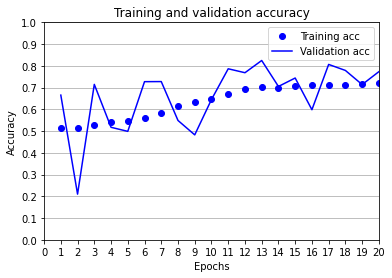

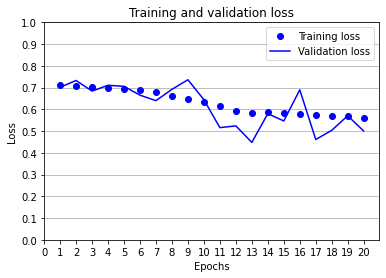

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
axes = plt.gca()
axes.set_xlim([0,20])
axes.set_ylim([0,1])
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax = plt.axes()        
ax.yaxis.grid()
axes.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
axes.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
axes1 = plt.gca()
axes1.set_ylim([0,1])
ax1 = plt.axes()        
ax1.yaxis.grid()
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
axes1.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
axes1.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.legend()
plt.show()

The graphs for different drop-out values are not in the code, but the process is the same, only changing the drop-out in the model. Here we show only the graphs for drop-out equal to 0.5


In [ ]:
# Fitting for the oversampling using SMOTE or RandomOverSampler
'''
from keras.callbacks import EarlyStopping, History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

history = model.fit(X_train,y_train, batch_size =264, epochs =20,callbacks=[
                              EarlyStopping(monitor='val_accuracy', patience=7,restore_best_weights=True), 
                              History()],
                              #ModelCheckpoint(filepath = 'model_zero7.{epoch:02d}-{val_loss:.6f}.hdf5',verbose=1, save_best_only=True, save_weights_only = True),
                              #ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=2, min_lr=0.000001, verbose=1)] , 
                              validation_data=(X_val,y_val)) 
'''

Epoch 1/20
68/68 [==============================] - 4s 66ms/step - loss: 0.7087 - accuracy: 0.5232 - val_loss: 0.7307 - val_accuracy: 0.3488
Epoch 2/20
68/68 [==============================] - 4s 63ms/step - loss: 0.6947 - accuracy: 0.5644 - val_loss: 0.7360 - val_accuracy: 0.4662
Epoch 3/20
68/68 [==============================] - 4s 62ms/step - loss: 0.6596 - accuracy: 0.6266 - val_loss: 0.6396 - val_accuracy: 0.6610
Epoch 4/20
68/68 [==============================] - 4s 63ms/step - loss: 0.6011 - accuracy: 0.6959 - val_loss: 0.6458 - val_accuracy: 0.6534
Epoch 5/20
68/68 [==============================] - 5s 66ms/step - loss: 0.5538 - accuracy: 0.7333 - val_loss: 0.5304 - val_accuracy: 0.7610
Epoch 6/20
68/68 [==============================] - 9s 138ms/step - loss: 0.5235 - accuracy: 0.7575 - val_loss: 0.5174 - val_accuracy: 0.7684
Epoch 7/20
68/68 [==============================] - 8s 117ms/step - loss: 0.5072 - accuracy: 0.7704 - val_loss: 0.5134 - val_accuracy: 0.7647
Epoch 8/20


## Prediction on test set

In [ ]:
# run only if the previous code is runned, otherwise go to the next section

from sklearn import metrics
from sklearn.metrics import classification_report

y_pred = model.predict(epoch_fin_test)

y_final = []

for i in range(len(y_pred)):
  if y_pred[i,1]>0.5:
    y_final.append(1)
  else:
    y_final.append(0)

y_final = np.array(y_final)

#Prediction load model
Here you can import models that are already saved and obtain the resulting metrics both for binary classification and letter prediction. The models we used are PCA10, PCA120, DS10, DS120 with KBBG. For the PCA120 (best model), we also have the Smote and ROS oversampling to make a comparison. 

In [ ]:
'''
import matplotlib.pyplot as plt   
import numpy as np                
import os                         
import pandas as pd
from pathlib import Path          
from scipy.io import loadmat      
from scipy import signal          
from tqdm.auto import tqdm  
import h5py
import keras
from collections import Counter
import csv
import tensorflow as tf

# here you import the test set of the model you are interested in
hf2 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/test_B_PCA_120.h5', 'r')
hf3 = h5py.File('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/stimulus_code_test.h5', 'r')

epoch_fin_test = hf2.get('dataset_epoch_test')
epoch_labels_binary_test = hf2.get('dataset_epoch_labels_test')
stimulus_code_test= hf3.get('StimulusCode')

chars_test = []

# Read file content
with open('/content/drive/MyDrive/workshop_neuro/dataset/B/TEST/target_chars_test.csv', "r") as f:
  file_content = f.read()
  
  # Loop over all rows (except first one)
  for row in file_content.split("','"): 
    chars_test.append(row)

epoch_fin_test = np.array(epoch_fin_test)
epoch_labels_binary_test =np.array(epoch_labels_binary_test)
stimulus_code_test=np.array(stimulus_code_test)
chars_test = np.array(chars_test)

# Load model of interest
filepath = Path('drive') / 'MyDrive'/'workshop_neuro'/'modelli_salvati'/'B'/'PCA_120_B'
loaded_model = tf.keras.models.load_model(filepath)
'''

## BINARY CLASSIFICATION


In [ ]:
'''
y_pred = loaded_model.predict(epoch_fin_test)

y_final = []
for i in range(len(y_pred)):
  if y_pred[i,1]>0.5:
    y_final.append(1)
  else:
    y_final.append(0)

y_final = np.array(y_final)
'''

# Metrics

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

cm=confusion_matrix(y_pred=y_final,y_true=epoch_labels_binary_test) 

TN=cm[0,0] 
FP=cm[0,1] 
FN=cm[1,0] 
TP=cm[1,1]

#Sensitivity:
Se=TP/(TP+FN)

#Specificity
Sp=TN/(TN+FP)

#Accuracy
Acc=accuracy_score(y_pred=y_final,y_true=epoch_labels_binary_test)

#Positive predicted value
PPV=TP/(TP+FP)

#Negative predictive value
NPV=TN/(TN+FN)

print("**********") 
print("  Metrics  ") 
print("**********") 
print("Accuracy = %.4f" % Acc) 
print("True positive = %d" % TP) 
print("True negative = %d" % TN) 
print("False positive = %d" % FP) 
print("False negative = %d" % FN) 
print("Sensitivity = %.4f" % Se) 
print("Specificity = %.4f" % Sp) 
print("Positive predicted value = %.4f" % PPV)
print("Negative predictive value = %.4f" % NPV)

**********
  Metrics  
**********
Accuracy = 0.7683
True positive = 1983
True negative = 11846
False positive = 3154
False negative = 1017
Sensitivity = 0.6610
Specificity = 0.7897
Positive predicted value = 0.3860
Negative predictive value = 0.9209


# LETTER PREDICTION

In [ ]:
MATRICE = [['A','B','C','D','E','F'], 
          ['G','H','I','J','K','L'],
          ['M','N','O','P','Q','R'],
           
          ['S','T','U','V','W','X'],
          ['Y','Z','1','2','3','4'],
          ['5','6','7','8','9','_']]

MATRICE = np.array(MATRICE)
chars_test[0]='M'
chars_test[-1]='R'

## Most common

In [ ]:
# Try to confirm algorithm with true labels of P300 and character target
import collections 
save_column= []
save_row= []
pred_char= [] #our prediction character will be a vector of size = n_char
n_trials=15
n_epochs=180
n_char=100
n_total=n_epochs*n_char

#Predict character 
for i in range(0, n_total, n_epochs): #iterate in y_final vector in intervals of 180. eg: start from 0 to 180, then 180 to 360
  for j in range(i, i+n_epochs-1):    #from 0 untill 0+179 -> first 180 group; 2nd iteration: from 180 untill 180+179...
    if y_final[j]==1 :
      if stimulus_code_test[j]<7 :
        save_column.append(stimulus_code_test[j])
      else :
        save_row.append(stimulus_code_test[j])

  row = collections.Counter(save_row).most_common(1)[0][0] 
  print('row  %s' % collections.Counter(save_row))
  row = int(row)
   
  column= collections.Counter(save_column).most_common(1)[0][0]
  print('column  %s' % collections.Counter(save_column))
  column= int(column) 
  
  pred_char.append(MATRICE[row-7, column-1]) #if row is 7 we want to give index = 0, if column=1 we want column=0.
  save_column= []
  save_row= []

pred_char = np.array(pred_char)


row  Counter({9.0: 9, 10.0: 6, 11.0: 4, 8.0: 3, 7.0: 2, 12.0: 2})
column  Counter({1.0: 12, 2.0: 6, 5.0: 4, 6.0: 4, 4.0: 1})
row  Counter({7.0: 9, 8.0: 6, 11.0: 5, 12.0: 5, 9.0: 3, 10.0: 2})
column  Counter({5.0: 6, 2.0: 5, 3.0: 5, 4.0: 4, 1.0: 2, 6.0: 2})
row  Counter({9.0: 11, 8.0: 7, 7.0: 5, 12.0: 2, 10.0: 2, 11.0: 1})
column  Counter({6.0: 12, 5.0: 7, 1.0: 4, 2.0: 3, 4.0: 1, 3.0: 1})
row  Counter({9.0: 8, 10.0: 7, 11.0: 6, 7.0: 4, 8.0: 3, 12.0: 2})
column  Counter({1.0: 9, 6.0: 4, 3.0: 4, 5.0: 2, 2.0: 1, 4.0: 1})
row  Counter({8.0: 10, 7.0: 7, 9.0: 4, 10.0: 1, 12.0: 1, 11.0: 1})
column  Counter({3.0: 10, 5.0: 7, 2.0: 5, 1.0: 2, 6.0: 2, 4.0: 1})
row  Counter({9.0: 9, 8.0: 5, 7.0: 5, 10.0: 5, 12.0: 2, 11.0: 1})
column  Counter({6.0: 8, 1.0: 6, 3.0: 6, 5.0: 5, 2.0: 4, 4.0: 3})
row  Counter({9.0: 13, 11.0: 6, 8.0: 5, 10.0: 4, 12.0: 2, 7.0: 1})
column  Counter({3.0: 9, 2.0: 6, 1.0: 5, 6.0: 2, 5.0: 1, 4.0: 1})
row  Counter({9.0: 11, 8.0: 7, 7.0: 6, 11.0: 2, 12.0: 2, 10.0: 1})
column  Cou

In [ ]:
count=0
save_ind= []
for i in range(len(pred_char)):
  if pred_char[i]!=chars_test[i]:
    save_ind.append(i)
    count=count+1
print('number of error letter predicted %i' % count)

number of error letter predicted 5


## Mean

In [ ]:
# mean
n_char=100
sum_matrix=np.zeros((12,n_char))
mean_matrix=np.zeros((12,n_char)) #for line = 0 this is stimulus code=1, line=1 stimulus_code=2 etc  
mean_rep = []
n_epochs=180
stim_code=0
count_matrix= np.zeros((12))

for k in range(15):
  for char in range(n_char): #0, 1,2,...
  
    for m in range(k+1):      #0,1, 2 ....14
      for j in range(n_epochs*char +12*m, (n_epochs*char+12 +12*m)): # (0,12 ; 12, 12+12...), (180, 180+12;)
      
        stim_code=stimulus_code_test[j]
        stim_code=int(stim_code)

        count_matrix[stim_code-1]=count_matrix[stim_code-1] +1
        sum_matrix[stim_code-1,char]= sum_matrix[stim_code-1,char] + y_pred[j,1]
      mean_matrix[:,char]= sum_matrix[:,char]/count_matrix[:]
  mean_rep.append(mean_matrix)
  count_matrix = np.zeros((12))
  sum_matrix=np.zeros((12,n_char))
  mean_matrix=np.zeros((12,n_char))
mean_rep = np.array(mean_rep)
mean_rep.shape

(15, 12, 100)

In [ ]:
letter_matrix = []
row=0
column=0
max_column=0
max_row=0
pred_char_media=[]

for k in range (15):
  for char in range(n_char):
    for i in range(12):
      if i<6:
        if max_column<mean_rep[k,i,char]:
          max_column=mean_rep[k,i,char]
          column=int(i)
        
      else:
        if max_row<mean_rep[k,i,char]:
          max_row=mean_rep[k,i,char]
          row=int(i)

    pred_char_media.append(MATRICE[row-6, column]) #if row is 7 we want to give index = 0, if column=1 we want column=0.
    max_column=0
    max_row=0

  letter_matrix.append(pred_char_media)
  pred_char_media=[]
  
letter_matrix= np.array(letter_matrix)

In [ ]:
count=np.zeros((15))
accuracy = np.zeros((15))
save_ind= []

for k in range(15):

  for i in range(100):
    
    if letter_matrix[k,i]!=chars_test[i]:
      
      count[k]=count[k]+1
      accuracy[k] = (1 - count[k]/len(chars_test))*100
  
  print('number of error letter predicted  %i' % count[k])
  print('accuracy  %i' % accuracy[k])

  count=np.zeros((15))

number of error letter predicted  65
accuracy  35
number of error letter predicted  51
accuracy  49
number of error letter predicted  45
accuracy  55
number of error letter predicted  42
accuracy  58
number of error letter predicted  32
accuracy  68
number of error letter predicted  23
accuracy  77
number of error letter predicted  18
accuracy  82
number of error letter predicted  13
accuracy  87
number of error letter predicted  14
accuracy  86
number of error letter predicted  8
accuracy  92
number of error letter predicted  4
accuracy  96
number of error letter predicted  2
accuracy  98
number of error letter predicted  2
accuracy  98
number of error letter predicted  2
accuracy  98
number of error letter predicted  3
accuracy  97


#.mat files for accuracy over repetition in MATLAB
Here is the code to save the accuracy variable over the repetitions in order to obtain a graph in matlab

In [ ]:
'''
import scipy.io as sio

adict = {}
adict['pkt_np_array2'] = accuracy
sio.savemat('/content/drive/MyDrive/workshop_neuro/matlab/letter_accuracyvsrep_B.mat', adict)
'''

"\nimport scipy.io as sio\n\nadict = {}\nadict['pkt_np_array2'] = accuracy\nsio.savemat('/content/drive/MyDrive/workshop_neuro/matlab/letter_accuracyvsrep_B.mat', adict)\n"

#Save network to compare results

In [ ]:
# Save model
'''
from tensorflow.keras.models import save_model, load_model
filepath = Path('drive') / 'MyDrive' / 'workshop_neuro'/'modelli_salvati'/'B' /'PCA_120_ROS_B'
#filepath = Path('drive') / 'MyDrive' /...
save_model(model, filepath)
'''

"\nfrom tensorflow.keras.models import save_model, load_model\nfilepath = Path('drive') / 'MyDrive' / 'workshop_neuro'/'modelli_salvati'/'B' /'PCA_120_ROS_B'\n#filepath = Path('drive') / 'MyDrive' /...\nsave_model(model, filepath)\n"